## Hyperparameter tuning

In [ ]:
#!pip install gymnax

In [2]:
import jax
import jax.numpy as jnp
import optax
import gymnax
import time
from gymnax.wrappers.purerl import FlattenObservationWrapper
import jax.tree_util as jtu

In [3]:
class ReplayBuffer:
    def __init__(self, capacity, obs_dim, n_envs):
        self.capacity = capacity
        self.n_envs = n_envs
        self.ptr = 0
        self.size = 0   # number of valid samples

        self.obs_buf = jnp.zeros((capacity, obs_dim))
        self.actions_buf = jnp.zeros((capacity,), dtype=jnp.int32)
        self.rewards_buf = jnp.zeros((capacity,))
        self.next_obs_buf = jnp.zeros((capacity, obs_dim))
        self.dones_buf = jnp.zeros((capacity,))

    def add(self, obs, actions, rewards, next_obs, dones):
        """
        Add a batch of transitions from all environments.
        obs: (n_envs, obs_dim)
        actions: (n_envs,)
        rewards: (n_envs,)
        next_obs: (n_envs, obs_dim)
        dones: (n_envs,)
        """
        n = obs.shape[0]
        idxs = (jnp.arange(n) + self.ptr) % self.capacity

        self.obs_buf = self.obs_buf.at[idxs].set(obs)
        self.actions_buf = self.actions_buf.at[idxs].set(actions)
        self.rewards_buf = self.rewards_buf.at[idxs].set(rewards)
        self.next_obs_buf = self.next_obs_buf.at[idxs].set(next_obs)
        self.dones_buf = self.dones_buf.at[idxs].set(dones)

        # advance pointer
        self.ptr = (self.ptr + n) % self.capacity
        # track current size
        self.size = min(self.size + n, self.capacity)

    def sample(self, rng, batch_size):
        max_size = self.size  # only sample from valid entries
        idxs = jax.random.randint(rng, (batch_size,), 0, max_size)
        return (self.obs_buf[idxs],
                self.actions_buf[idxs],
                self.rewards_buf[idxs],
                self.next_obs_buf[idxs],
                self.dones_buf[idxs])

    def __len__(self):
        return self.size


In [4]:
def rbf_features(x, centers, sigma=0.5):
    # x: (d,) or (batch_size, d), centers: (n_centers, d)

    # Normalize input to appropriate range for CartPole
    x= x / jnp.array([2.4, 3.0, 0.2, 3.0])  # CartPole observation scaling

    diffs = x[None] - centers if x.ndim == 1 else x[:, None] - centers
    sq_dist = jnp.sum(diffs**2, axis=-1)
    return jnp.exp(-sq_dist / (2 * sigma**2))

def init_params(rng, n_features, n_actions):
    W = jax.random.normal(rng, (n_features, n_actions)) * 0.1
    return W

def q_values(W, obs, centers, sigma=0.5):
    phi = rbf_features(obs, centers, sigma)  # (batch_size, n_features) or (n_features,)
    return jnp.dot(phi, W)  # (batch_size, n_actions) or (n_actions,)

def select_action(W, obs, rng, centers, sigma=0.5, epsilon=0.1):
    q = q_values(W, obs, centers, sigma)
    greedy = jnp.argmax(q, axis=-1)
    explore = jax.random.bernoulli(rng, epsilon, shape=greedy.shape)
    random_actions = jax.random.randint(rng, greedy.shape, 0, q.shape[-1])
    return jnp.where(explore, random_actions, greedy)

def td_loss(W, obs, action, reward, next_obs, done, gamma, centers, sigma):
    q = q_values(W, obs, centers, sigma)
    q_selected = jnp.take_along_axis(q, action[:, None], axis=-1).squeeze()

    next_q = jnp.max(q_values(W, next_obs, centers, sigma), axis=-1)
    target = reward + gamma * (1 - done) * next_q

    return jnp.mean(0.5 * (q_selected - target) ** 2)

def epsilon_schedule(step, eps_start=1.0, eps_end=0.05, decay_rate=0.999):
    return jnp.maximum(eps_end, eps_start * (decay_rate ** step))

In [9]:
# Wrap the environment to ensure consistent observation shapes
env, env_params = gymnax.make("CartPole-v1")
env = FlattenObservationWrapper(env)
env_params = env_params

def train_one(rng, hyperparams, log_interval=1):
    """
    Returns:
      steps_per_ep: array (num_episodes,)
      times_per_ep: array (num_episodes,)
      avg_rewards: array (num_episodes,)
      solved_at_step: int (or -1 if unsolved)
    """

    num_episodes = hyperparams["num_episodes"]
    lr = hyperparams["lr"]
    gamma = hyperparams["gamma"]
    n_centers = hyperparams["n_centers"]
    sigma = hyperparams["sigma"]
    num_envs = hyperparams["num_envs"]
    batch_size = hyperparams["batch_size"]

    obs_dim = env.observation_space(env_params).shape[0]
    n_actions = env.action_space(env_params).n

    # initialize params
    rng, centers_rng, init_rng = jax.random.split(rng, 3)
    centers = jax.random.uniform(centers_rng, (n_centers, obs_dim), minval=-1, maxval=1)
    W = init_params(init_rng, n_centers, n_actions)

    # initialize optimizer
    opt = optax.adam(lr)
    opt_state = opt.init(W)

    # parallelize reset step and select action
    vmap_reset = jax.vmap(env.reset, in_axes=(0, None))
    vmap_step = jax.jit(jax.vmap(env.step, in_axes=(0, 0, 0, None)))
    vmap_select_action = jax.vmap(select_action, in_axes=(None, 0, 0, None, None, None))

    @jax.jit
    def update_batch(W, opt_state, obs, actions, rewards, next_obs, dones):
        def batch_loss(W):
            return td_loss(W, obs, actions, rewards, next_obs, dones, gamma, centers, sigma)

        grads = jax.grad(batch_loss)(W)
        updates, opt_state = opt.update(grads, opt_state, W)
        W = optax.apply_updates(W, updates)
        return W, opt_state

    # reset env
    rng, *env_rngs = jax.random.split(rng, num_envs + 1)
    obs, states = vmap_reset(jnp.array(env_rngs), env_params)

    # initialize rewards
    episode_rewards = jnp.zeros(num_envs)
    buffer = ReplayBuffer(capacity=100000, obs_dim=obs_dim, n_envs=num_envs)

    steps = 0
    solved_at = -1

    steps_per_ep = []
    times_per_ep = []
    rewards_per_ep = []

    t0 = time.perf_counter()

    for steps in range(1000):
        rng, action_rng = jax.random.split(rng)
        action_rngs = jax.random.split(action_rng, num_envs)

        epsilon = epsilon_schedule(steps, eps_start=1.0, eps_end=0.01, decay_rate = 0.999)

        actions = vmap_select_action(W, obs, jnp.array(action_rngs), centers, sigma, epsilon)
        rng, *step_rngs = jax.random.split(rng, num_envs + 1)
        next_obs, next_states, rewards, dones, _ = vmap_step(
            jnp.array(step_rngs), states, actions, env_params
        )

        buffer.add(obs, actions, rewards, next_obs, dones.astype(jnp.float32))
        episode_rewards += rewards

        completed_mask = dones.astype(bool)
        completed_rewards = episode_rewards[completed_mask]

        if completed_rewards.size > 0:
            for r in completed_rewards.tolist():
                steps_per_ep.append(steps)
                times_per_ep.append(time.perf_counter() - t0)
                rewards_per_ep.append(r)

        episode_rewards = episode_rewards * (1 - dones.astype(jnp.float32))

        rng, reset_rng = jax.random.split(rng)
        reset_rngs = jax.random.split(reset_rng, num_envs)
        reset_obs, reset_states = vmap_reset(jnp.array(reset_rngs), env_params)

        obs = jnp.where(dones[:, None], reset_obs, next_obs)
        states = jtu.tree_map(lambda r, n: jnp.where(dones, r, n), reset_states, next_states)

        #
        rng, sample_rng = jax.random.split(rng)
        batch_obs, batch_actions, batch_rewards, batch_next_obs, batch_dones = \
            buffer.sample(sample_rng, batch_size)
        W, opt_state = update_batch(W, opt_state,
                                    batch_obs, batch_actions, batch_rewards,
                                    batch_next_obs, batch_dones)

    return (jnp.array(steps_per_ep),
            jnp.array(times_per_ep),
            jnp.array(rewards_per_ep),
            solved_at)


In [ ]:
hyperparams_list = [
    {"lr": 1e-3, "batch_size": 32, "sigma": 0.5, "n_centers": 200, "num_envs": 16, "num_episodes": 500, "gamma": 0.95},
    {"lr": 5e-3, "batch_size": 64, "sigma": 0.5, "n_centers": 500, "num_envs": 16, "num_episodes": 500, "gamma": 0.99},
    {"lr": 1e-2, "batch_size": 128, "sigma": 1.0, "n_centers": 500, "num_envs": 16, "num_episodes": 500, "gamma": 0.99},
    {"lr": 5e-3, "batch_size": 64, "sigma": 0.1, "n_centers": 300, "num_envs": 16, "num_episodes": 500, "gamma": 0.95},
    {"lr": 1e-2, "batch_size": 256, "sigma": 0.5, "n_centers": 500, "num_envs": 16, "num_episodes": 500, "gamma": 0.99},
    {"lr": 1e-3, "batch_size": 32, "sigma": 0.5, "n_centers": 500, "num_envs": 16, "num_episodes": 500, "gamma": 0.90},
    {"lr": 5e-4, "batch_size": 256, "sigma": 0.5, "n_centers": 500, "num_envs": 16, "num_episodes": 500, "gamma": 0.99},
]

rng = jax.random.PRNGKey(0)

results = []
for i, cfg in enumerate(hyperparams_list):
    rng, subkey = jax.random.split(rng)
    steps, times, rewards, solved_at = train_one(subkey, cfg)
    results.append({"cfg": cfg, "steps": steps, "times": times, "rewards": rewards, "solved_at": solved_at})
    print(f"Finished run {i+1}/{len(hyperparams_list)}")


Finished run 1/7
Finished run 2/7
Finished run 3/7
Finished run 4/7
Finished run 5/7
Finished run 6/7
Finished run 7/7


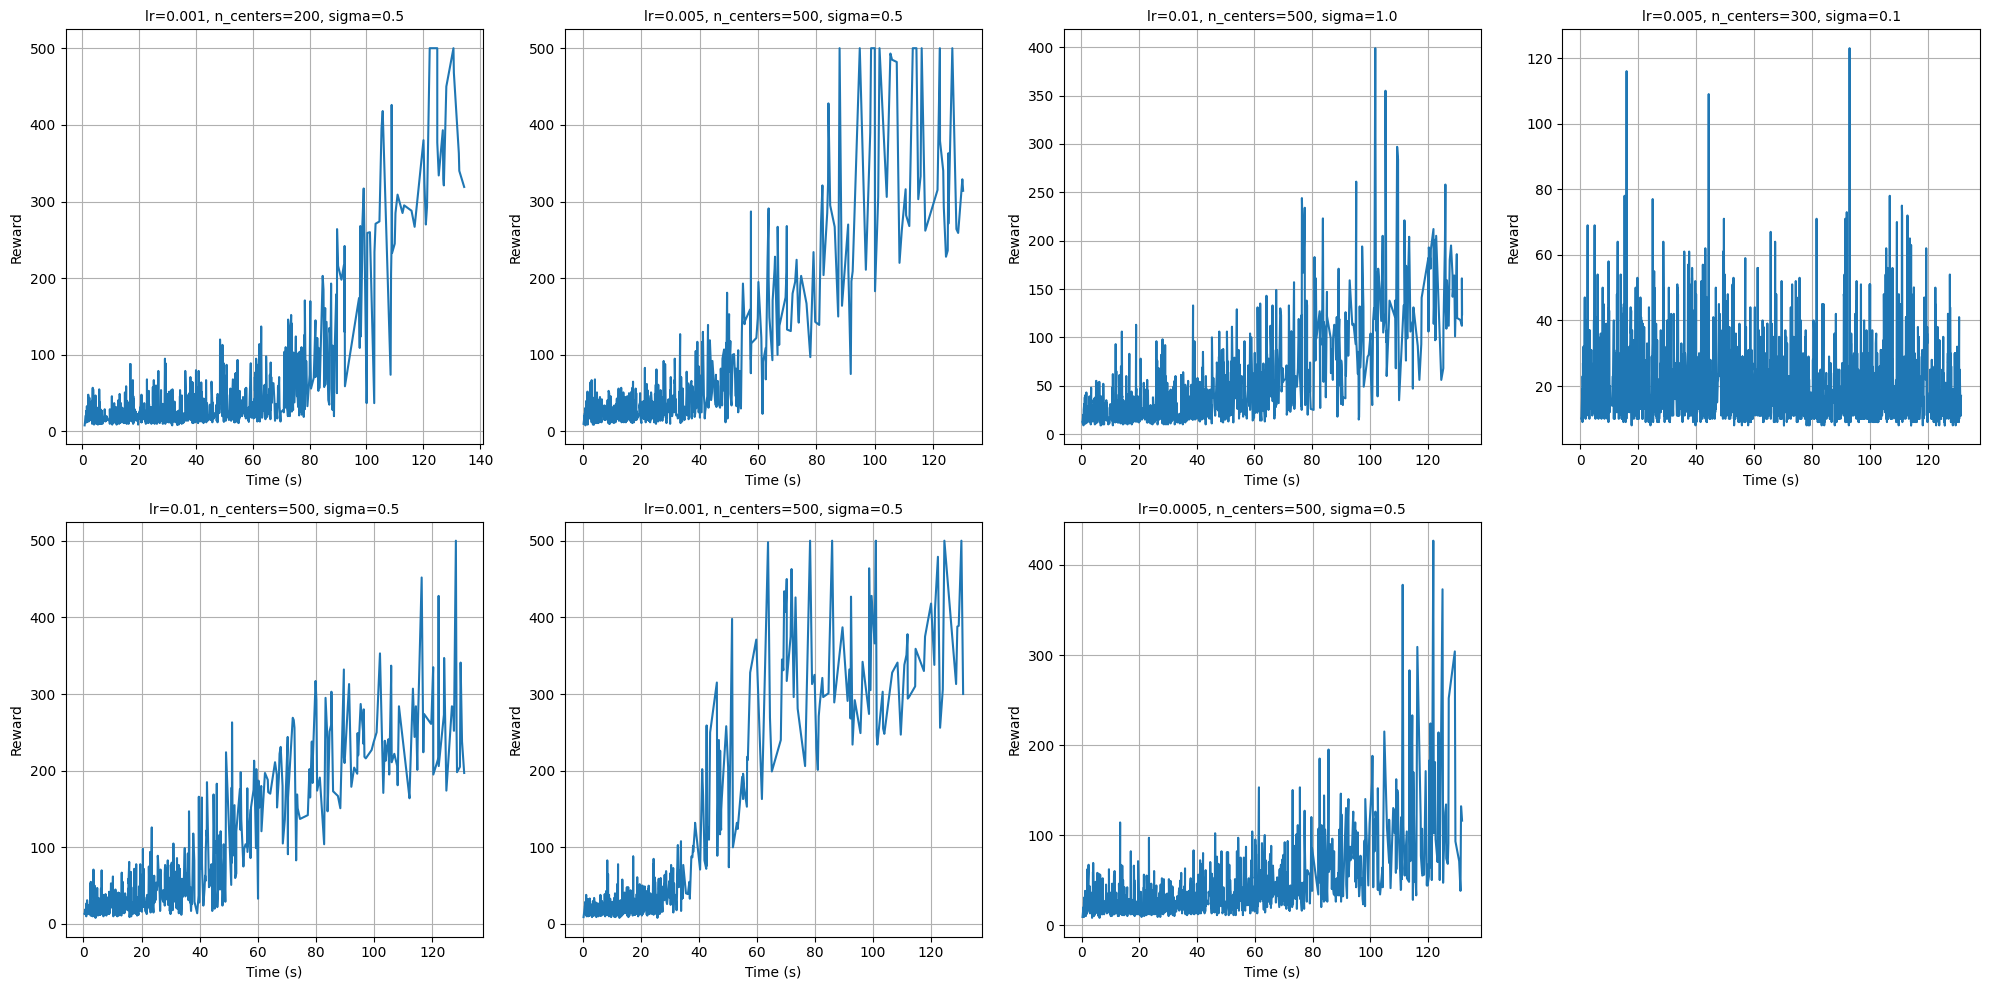

In [ ]:
import matplotlib.pyplot as plt

n_rows = 2
n_cols = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10))
axes = axes.flatten()  # flatten for easy indexing

for i, res in enumerate(results):
    if i >= n_rows * n_cols:
        break  # only plot up to 8 runs
    cfg = res["cfg"]
    label = f"lr={cfg['lr']}, n_centers={cfg['n_centers']}, sigma={cfg['sigma']}"

    axes[i].plot(res["times"], res["rewards"])
    axes[i].set_title(label, fontsize=10)
    axes[i].set_xlabel("Time (s)")
    axes[i].set_ylabel("Reward")
    axes[i].grid(True)

# Hide any unused subplots
for j in range(i+1, n_rows * n_cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


## Maximizing GPU usage


In [16]:
import time
import jax
import jax.numpy as jnp
import gymnax
from gymnax.wrappers.purerl import FlattenObservationWrapper

# Make env
env, env_params = gymnax.make("CartPole-v1")
env = FlattenObservationWrapper(env)

# Vectorized reset/step
vmap_reset = jax.jit(jax.vmap(env.reset, in_axes=(0, None)))
vmap_step = jax.jit(jax.vmap(env.step, in_axes=(0, 0, 0, None)))

def benchmark_env(num_envs, num_steps=200):
    """Benchmark env.step with num_envs parallel environments"""
    rng = jax.random.PRNGKey(0)
    rng, *env_rngs = jax.random.split(rng, num_envs + 1)
    obs, states = vmap_reset(jnp.array(env_rngs), env_params)

    # Ensure arrays are on GPU
    obs = jax.device_put(obs)
    states = jax.device_put(states)

    rng, *step_rngs = jax.random.split(rng, num_envs + 1)
    actions = jnp.zeros((num_envs,), dtype=jnp.int32)  # dummy actions

    # Warmup compile
    next_obs, next_states, rewards, dones, _ = vmap_step(
        jnp.array(step_rngs), states, actions, env_params
    )

    # Benchmark loop
    start = time.perf_counter()
    for _ in range(num_steps):
        rng, *step_rngs = jax.random.split(rng, num_envs + 1)
        next_obs, next_states, rewards, dones, _ = vmap_step(
            jnp.array(step_rngs), states, actions, env_params
        )
    jax.block_until_ready(next_obs)  # ensure completion
    elapsed = time.perf_counter() - start

    fps = (num_envs * num_steps) / elapsed
    return elapsed, fps

# Sweep different env counts
for num_envs in [16, 32, 64, 128 ,256, 512, 1024, 2048, 4096, 8192, 16384]:
    elapsed, fps = benchmark_env(num_envs)
    print(f"num_envs={num_envs:6d} | elapsed={elapsed:.3f}s")


num_envs=    16 | elapsed=1.081s
num_envs=    32 | elapsed=1.804s
num_envs=    64 | elapsed=4.159s
num_envs=   128 | elapsed=7.225s
num_envs=   256 | elapsed=14.020s
num_envs=   512 | elapsed=28.241s


KeyboardInterrupt: 

In [29]:
import time
import jax
import jax.numpy as jnp
import gymnax
from gymnax.wrappers.purerl import FlattenObservationWrapper

# Make env
env, env_params = gymnax.make("CartPole-v1")
env = FlattenObservationWrapper(env)

# Vectorized reset/step
vmap_reset = jax.jit(jax.vmap(env.reset, in_axes=(0, None)))
vmap_step = jax.jit(jax.vmap(env.step, in_axes=(0, 0, 0, None)))

def benchmark_env(num_envs, num_steps=200):
    """Benchmark env.step with num_envs parallel environments using scan."""
    # Define step_scan inside benchmark_env to capture num_envs via closure
    def step_scan(carry, step_keys):
        """Single step function for jax.lax.scan."""
        states, rng = carry
        rng, step_rng = jax.random.split(rng)  # Split for next iteration
        actions = jnp.zeros((num_envs,), dtype=jnp.int32)  # Dummy actions
        next_obs, next_states, rewards, dones, _ = vmap_step(
            step_keys, states, actions, env_params
        )
        return (next_states, rng), (next_obs, rewards, dones)

    rng = jax.random.PRNGKey(0)

    # Pre-generate random keys for resets and steps
    rng, reset_rng, step_rng = jax.random.split(rng, 3)
    reset_rngs = jax.random.split(reset_rng, num_envs)

    # Generate num_steps * num_envs keys, reshape to (num_steps, num_envs, 2)
    step_rngs = jax.random.split(step_rng, num_steps * num_envs)
    step_rngs = step_rngs.reshape(num_steps, num_envs, 2)

    # Initialize environments
    obs, states = vmap_reset(reset_rngs, env_params)

    # Ensure arrays are on GPU
    obs = jax.device_put(obs)
    states = jax.device_put(states)
    step_rngs = jax.device_put(step_rngs)

    # Warm-up compile
    _, _ = step_scan((states, rng), step_rngs[0])
    jax.block_until_ready(_)  # Ensure warm-up completion

    # Benchmark scan
    start = time.perf_counter()
    (final_states, _), (obs_history, rewards_history, dones_history) = jax.lax.scan(
        step_scan, (states, rng), step_rngs
    )
    jax.block_until_ready(final_states)  # Ensure completion
    elapsed = time.perf_counter() - start

    fps = (num_envs * num_steps) / elapsed
    return elapsed, fps

# Sweep different env counts
for num_envs in [10, 100, 1000, 10000, 100000, 1000000]:
    elapsed, fps = benchmark_env(num_envs)
    print(f"num_envs={num_envs:6d} | elapsed={elapsed:.3f}s | fps={fps:.2f}")

num_envs=    10 | elapsed=2.560s | fps=781.30
num_envs=   100 | elapsed=0.940s | fps=21281.86
num_envs=  1000 | elapsed=0.924s | fps=216499.53
num_envs= 10000 | elapsed=0.855s | fps=2339227.44
num_envs=100000 | elapsed=1.032s | fps=19386158.56


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 3200000000 bytes.